In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import gridspec as gridspec

import os
import warnings



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [ ]:
def set_seed(seed = 31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [ ]:
ds_train_ = image_dataset_from_directory('./archive/train',
                                        labels = 'inferred',
                                        label_mode = 'binary',
                                        image_size = [128, 128],
                                        batch_size = 64,
                                        interpolation = 'nearest',
                                        shuffle = True,)
ds_valid_ = image_dataset_from_directory('./archive/valid',  labels = 'inferred',
                                        label_mode = 'binary',
                                        image_size = [128, 128],
                                        batch_size = 64,
                                        interpolation = 'nearest',
                                        shuffle = True,)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [ ]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters = 32,
                  kernel_size = 3,
                  activation = 'relu',
                  padding = 'same',
                  input_shape = (128, 128, 3)),
    layers.MaxPool2D(),
    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size = 3,activation='relu',padding='same'),
    layers.Conv2D(filters=128, kernel_size = 3,activation='relu',padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(epsilon=0.01),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 30,
    verbose = 1,
    callbacks = [early_stop]
)

Epoch 1/30


80/80 [==============================] - 79s 962ms/step - loss: 0.6738 - binary_accuracy: 0.5855 - val_loss: 0.6604 - val_binary_accuracy: 0.6183
Epoch 2/30
80/80 [==============================] - 65s 812ms/step - loss: 0.6607 - binary_accuracy: 0.6054 - val_loss: 0.6522 - val_binary_accuracy: 0.6284
Epoch 3/30
80/80 [==============================] - 73s 915ms/step - loss: 0.6556 - binary_accuracy: 0.6121 - val_loss: 0.6425 - val_binary_accuracy: 0.6351
Epoch 4/30
80/80 [==============================] - 75s 945ms/step - loss: 0.6461 - binary_accuracy: 0.6230 - val_loss: 0.6319 - val_binary_accuracy: 0.6343
Epoch 5/30
80/80 [==============================] - 75s 946ms/step - loss: 0.6351 - binary_accuracy: 0.6306 - val_loss: 0.6292 - val_binary_accuracy: 0.6415
Epoch 6/30
80/80 [==============================] - 76s 947ms/step - loss: 0.6290 - binary_accuracy: 0.6414 - val_loss: 0.6163 - val_binary_accuracy: 0.6510
Epoch 7/30
80/80 [==============================] - 75s 

<Axes: >

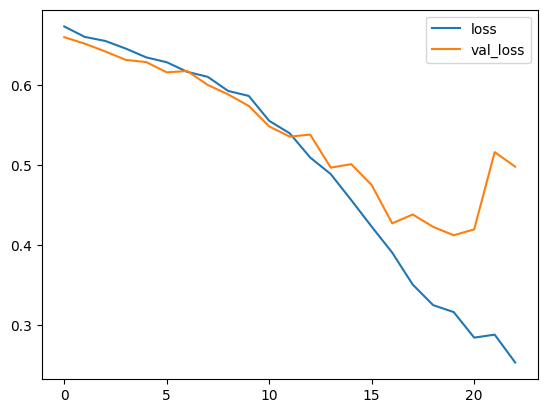

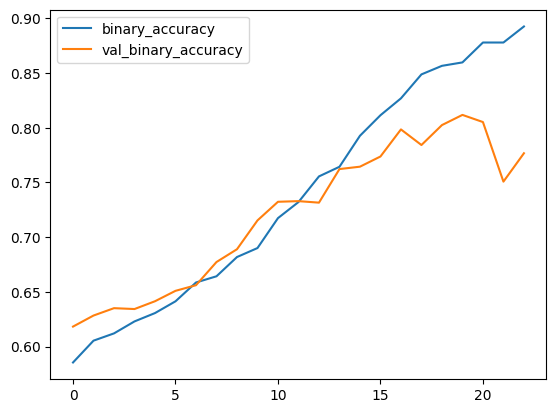

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
model.save("model.h5")


d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [2]:
import numpy as np
import tensorflow as tf

print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)


NumPy: 1.26.4
TensorFlow: 2.15.0
